<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Data Analytics Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block> 
        <font size=3>Homework 2</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:mersad.esalati@gmail.com">Mersad Esalati</a><br></font><br>
    </div>
</div>

# Selenium

## Weather Info Crawler
Daily Weather Information:
- Temperature (°F) - only Avg metric
- Dew Point (°F) - only Avg metric
- Humidity (%) - only Avg metric
- Wind Speed (mph) - only Avg metric
- Pressure (in) - only Avg metric
- Precipitation (in) - only Avg metric
- date

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import datetime
from tqdm.auto import tqdm

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [2]:
# crawl data + save into csv files

class TableState:
    def __init__(self):
        self.current_state = 0
        self.state_names = {
            0: "idle",
            1: "temperature",
            2: "dew_point",
            3: "humidity",
            4: "wind_speed",
            5: "pressure",
            6: "precipitation",
            7: "end"
        } 
    
    def get_current_state(self):
        return self.state_names[self.current_state]
    
    def next_state(self):
        self.current_state += 1

def infer_types(df):
    for col in df.columns:
        if col == "date":
            df[col] = pd.to_datetime(df[col])
        else:
            df[col] = pd.to_numeric(df[col])
    return df

def parse_weather(month: int) -> pd.DataFrame:
    weather_url = lambda month: f"https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-{month:02d}"
    print(weather_url(month))
    wd = webdriver.Chrome('chromedriver', options=chrome_options)
    wd.get(weather_url(month))
    rows = WebDriverWait(wd, 30).until(
        EC.visibility_of_all_elements_located(
            (By.XPATH, "//*[@class='observation-table ng-star-inserted']")))

    table_state = TableState()
    table_values = dict()
    for row in rows[0].find_elements(By.XPATH, ".//tr"):
        tds = [td.text for td in row.find_elements(By.XPATH, ".//td")]
        # print(tds)
        if tds == ['Max', 'Avg', 'Min'] or tds == ['Total']:
            table_state.next_state()
            state = table_state.get_current_state()
            table_values[state] = table_values.get(state, list())
        else:
            state = table_state.get_current_state()
            if state != "idle" and len(tds) == 3:
                table_values[state].append(tds[1])  # Avg
            if state == "precipitation" and len(tds) == 1:
                table_values[state].append(tds[0])  # Avg
    try:
        table_values["date"] = [datetime.date(year=2021, month=month, day=day) for 
                                day in range(1, len(table_values["temperature"]) + 1)]
    except:  # There is one extra row in the table
        for key in table_values.keys():
            table_values[key] = table_values[key][:-1]  # Last one is not in the month
        table_values["date"] = [datetime.date(year=2021, month=month, day=day) for 
                                day in range(1, len(table_values["temperature"]) + 1)]
    table_df = infer_types(pd.DataFrame(table_values))
    return table_df

weather_df_list = list()
for month in tqdm(range(1, 13)):
    weather_df_list.append(parse_weather(month))

  0%|          | 0/12 [00:00<?, ?it/s]

https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-01
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-02
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-03
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-04
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-05
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-06
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-07
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-08
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-09
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-10
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-11
https://www.wunderground.com/history/monthly/us/va/arlington/KDCA/date/2021-12


In [3]:
weather_df_list[-1]

,temperature,dew_point,humidity,wind_speed,pressure,precipitation,date
0,45.4,32.4,63.2,4.6,30.1,0.00,2021-12-01
1,54.7,39.9,59.2,9.4,29.8,0.00,2021-12-02
2,51.1,31.1,47.0,11.1,30.0,0.00,2021-12-03
3,49.0,33.4,57.3,3.5,30.1,0.00,2021-12-04
4,46.1,29.0,53.5,3.6,30.3,0.00,2021-12-05
5,54.4,39.9,60.5,13.8,29.9,0.00,2021-12-06
6,39.5,15.2,37.7,8.3,30.2,0.00,2021-12-07
7,39.9,24.4,54.0,6.5,30.0,0.00,2021-12-08
8,38.3,22.1,52.9,7.3,30.2,0.00,2021-12-09
9,46.6,34.6,63.5,4.9,30.1,0.00,2021-12-10


In [4]:
# Save csv
! mkdir ./weather/
for idx, weather_df in enumerate(weather_df_list):
    path = f"weather/weather_2021_{idx + 1:02d}.csv"
    weather_df.to_csv(path)
! zip ./weather.zip ./weather/*

  adding: weather/weather_2021_01.csv (deflated 60%)
  adding: weather/weather_2021_02.csv (deflated 58%)
  adding: weather/weather_2021_03.csv (deflated 59%)
  adding: weather/weather_2021_04.csv (deflated 59%)
  adding: weather/weather_2021_05.csv (deflated 59%)
  adding: weather/weather_2021_06.csv (deflated 59%)
  adding: weather/weather_2021_07.csv (deflated 61%)
  adding: weather/weather_2021_08.csv (deflated 61%)
  adding: weather/weather_2021_09.csv (deflated 60%)
  adding: weather/weather_2021_10.csv (deflated 60%)
  adding: weather/weather_2021_11.csv (deflated 60%)
  adding: weather/weather_2021_12.csv (deflated 60%)


## Download Capitalbikeshare Data
You can write script for download and extracting files or do it manualy.

In [5]:
for month in tqdm(range(1, 13)):
    path = f"2021{month:02d}-capitalbikeshare-tripdata.zip"
    download_path = f"https://s3.amazonaws.com/capitalbikeshare-data/{path}"
    ! wget -q --show-progress {download_path}
    ! unzip {path}

  0%|          | 0/12 [00:00<?, ?it/s]

202101-capitalbikes 100%[===================>]   3.45M  18.1MB/s    in 0.2s    
Archive:  202101-capitalbikeshare-tripdata.zip
  inflating: 202101-capitalbikeshare-tripdata.csv  
  inflating: __MACOSX/._202101-capitalbikeshare-tripdata.csv  
202102-capitalbikes 100%[===================>]   2.65M  14.3MB/s    in 0.2s    
Archive:  202102-capitalbikeshare-tripdata.zip
  inflating: 202102-capitalbikeshare-tripdata.csv  
  inflating: __MACOSX/._202102-capitalbikeshare-tripdata.csv  
202103-capitalbikes 100%[===================>]   5.60M  25.4MB/s    in 0.2s    
Archive:  202103-capitalbikeshare-tripdata.zip
  inflating: 202103-capitalbikeshare-tripdata.csv  
  inflating: __MACOSX/._202103-capitalbikeshare-tripdata.csv  
202104-capitalbikes 100%[===================>]   7.27M  27.9MB/s    in 0.3s    
Archive:  202104-capitalbikeshare-tripdata.zip
  inflating: 202104-capitalbikeshare-tripdata.csv  
  inflating: __MACOSX/._202104-capitalbikeshare-tripdata.csv  
202105-capitalbikes 100%[=======

## Question 1: Merge Weather Info Dataframes

In [15]:
weather_df = pd.concat(weather_df_list, axis=0).reset_index()
weather_df

,index,temperature,dew_point,humidity,wind_speed,pressure,precipitation,date
0,0,37.4,32.2,82.6,7.8,30.3,0.00,2021-01-01
1,1,43.8,38.5,83.4,7.0,30.0,0.81,2021-01-02
2,2,40.5,37.4,89.1,7.8,30.0,0.19,2021-01-03
3,3,40.4,34.3,79.9,5.9,30.0,0.09,2021-01-04
4,4,40.9,35.2,80.5,6.9,29.9,0.00,2021-01-05
...,...,...,...,...,...,...,...,...
360,26,41.3,31.0,67.0,6.5,30.0,0.00,2021-12-27
361,27,48.2,32.8,59.2,4.5,29.9,0.00,2021-12-28
362,28,50.2,40.5,70.1,5.0,29.8,0.00,2021-12-29
363,29,50.6,47.8,90.0,4.3,29.9,0.26,2021-12-30


<blockquote>

As 2021 is not a leap year, 365 rows verifies our crawling results.

## Question 2: Merge Capitalbikeshare Dataframes

In [16]:
bike_df = pd.DataFrame()
for month in tqdm(range(1, 13)):
    bike_df = bike_df.append(pd.read_csv(f"2021{month:02d}-capitalbikeshare-tripdata.csv"))
bike_df

  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,13A48BD20CC3DD85,classic_bike,2021-01-08 17:58:48,2021-01-08 18:25:23,Connecticut Ave & Yuma St NW,31318.0,Georgia Ave & Emerson St NW,31405.0,38.947156,-77.065115,38.949662,-77.027333,casual
1,CA68C580B32EEE66,electric_bike,2021-01-08 22:05:51,2021-01-08 22:23:52,8th & D St NW,31270.0,14th & D St SE,31663.0,38.894804,-77.023091,38.884053,-76.986043,member
2,5A925307814D5C2B,classic_bike,2021-01-21 17:20:31,2021-01-21 17:23:24,Wilson Blvd. & N. Vermont St.,31926.0,George Mason Dr & Wilson Blvd,31036.0,38.879477,-77.114563,38.878870,-77.120700,member
3,B6B2DB54A2B233EE,classic_bike,2021-01-28 10:06:30,2021-01-28 10:20:54,Franklin St & S Washington St,31907.0,Braddock Rd Metro,31047.0,38.798133,-77.048700,38.814577,-77.052808,member
4,921A142D5C8A9759,classic_bike,2021-01-11 12:09:45,2021-01-11 12:20:15,St. Asaph & Montgomery St,31931.0,Braddock Rd Metro,31047.0,38.814185,-77.043809,38.814577,-77.052808,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190842,8C999F60CA429723,classic_bike,2021-12-15 18:26:44,2021-12-15 18:34:25,14th & Belmont St NW,31119.0,14th & Rhode Island Ave NW,31203.0,38.921074,-77.031887,38.908600,-77.032300,casual
190843,CA9B6486BDC1D25A,electric_bike,2021-12-15 00:45:55,2021-12-15 00:49:46,14th & Belmont St NW,31119.0,14th & Irving St NW,31124.0,38.920981,-77.031653,38.928552,-77.032224,casual
190844,95957793A0807E8B,classic_bike,2021-12-06 14:17:45,2021-12-06 14:29:26,15th & P St NW,31201.0,14th & Irving St NW,31124.0,38.909801,-77.034427,38.928552,-77.032224,member
190845,99DA9A8F72185C79,docked_bike,2021-12-29 14:59:01,2021-12-29 16:29:40,10th St & L'Enfant Plaza SW,31287.0,10th St & L'Enfant Plaza SW,31287.0,38.884323,-77.026010,38.884323,-77.026010,casual


## Question 3: Data Cleaning

In [17]:
#a
bike_df = bike_df.dropna()
bike_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,13A48BD20CC3DD85,classic_bike,2021-01-08 17:58:48,2021-01-08 18:25:23,Connecticut Ave & Yuma St NW,31318.0,Georgia Ave & Emerson St NW,31405.0,38.947156,-77.065115,38.949662,-77.027333,casual
1,CA68C580B32EEE66,electric_bike,2021-01-08 22:05:51,2021-01-08 22:23:52,8th & D St NW,31270.0,14th & D St SE,31663.0,38.894804,-77.023091,38.884053,-76.986043,member
2,5A925307814D5C2B,classic_bike,2021-01-21 17:20:31,2021-01-21 17:23:24,Wilson Blvd. & N. Vermont St.,31926.0,George Mason Dr & Wilson Blvd,31036.0,38.879477,-77.114563,38.878870,-77.120700,member
3,B6B2DB54A2B233EE,classic_bike,2021-01-28 10:06:30,2021-01-28 10:20:54,Franklin St & S Washington St,31907.0,Braddock Rd Metro,31047.0,38.798133,-77.048700,38.814577,-77.052808,member
4,921A142D5C8A9759,classic_bike,2021-01-11 12:09:45,2021-01-11 12:20:15,St. Asaph & Montgomery St,31931.0,Braddock Rd Metro,31047.0,38.814185,-77.043809,38.814577,-77.052808,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190842,8C999F60CA429723,classic_bike,2021-12-15 18:26:44,2021-12-15 18:34:25,14th & Belmont St NW,31119.0,14th & Rhode Island Ave NW,31203.0,38.921074,-77.031887,38.908600,-77.032300,casual
190843,CA9B6486BDC1D25A,electric_bike,2021-12-15 00:45:55,2021-12-15 00:49:46,14th & Belmont St NW,31119.0,14th & Irving St NW,31124.0,38.920981,-77.031653,38.928552,-77.032224,casual
190844,95957793A0807E8B,classic_bike,2021-12-06 14:17:45,2021-12-06 14:29:26,15th & P St NW,31201.0,14th & Irving St NW,31124.0,38.909801,-77.034427,38.928552,-77.032224,member
190845,99DA9A8F72185C79,docked_bike,2021-12-29 14:59:01,2021-12-29 16:29:40,10th St & L'Enfant Plaza SW,31287.0,10th St & L'Enfant Plaza SW,31287.0,38.884323,-77.026010,38.884323,-77.026010,casual


In [19]:
#b
# https://www.w3schools.com/python/pandas/pandas_cleaning_wrong_format.asp

bike_df["started_at"] = pd.to_datetime(bike_df["started_at"])
bike_df["ended_at"] = pd.to_datetime(bike_df["ended_at"])
bike_df = bike_df.dropna()
print(bike_df.dtypes)
bike_df

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,13A48BD20CC3DD85,classic_bike,2021-01-08 17:58:48,2021-01-08 18:25:23,Connecticut Ave & Yuma St NW,31318.0,Georgia Ave & Emerson St NW,31405.0,38.947156,-77.065115,38.949662,-77.027333,casual
1,CA68C580B32EEE66,electric_bike,2021-01-08 22:05:51,2021-01-08 22:23:52,8th & D St NW,31270.0,14th & D St SE,31663.0,38.894804,-77.023091,38.884053,-76.986043,member
2,5A925307814D5C2B,classic_bike,2021-01-21 17:20:31,2021-01-21 17:23:24,Wilson Blvd. & N. Vermont St.,31926.0,George Mason Dr & Wilson Blvd,31036.0,38.879477,-77.114563,38.878870,-77.120700,member
3,B6B2DB54A2B233EE,classic_bike,2021-01-28 10:06:30,2021-01-28 10:20:54,Franklin St & S Washington St,31907.0,Braddock Rd Metro,31047.0,38.798133,-77.048700,38.814577,-77.052808,member
4,921A142D5C8A9759,classic_bike,2021-01-11 12:09:45,2021-01-11 12:20:15,St. Asaph & Montgomery St,31931.0,Braddock Rd Metro,31047.0,38.814185,-77.043809,38.814577,-77.052808,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190842,8C999F60CA429723,classic_bike,2021-12-15 18:26:44,2021-12-15 18:34:25,14th & Belmont St NW,31119.0,14th & Rhode Island Ave NW,31203.0,38.921074,-77.031887,38.908600,-77.032300,casual
190843,CA9B6486BDC1D25A,electric_bike,2021-12-15 00:45:55,2021-12-15 00:49:46,14th & Belmont St NW,31119.0,14th & Irving St NW,31124.0,38.920981,-77.031653,38.928552,-77.032224,casual
190844,95957793A0807E8B,classic_bike,2021-12-06 14:17:45,2021-12-06 14:29:26,15th & P St NW,31201.0,14th & Irving St NW,31124.0,38.909801,-77.034427,38.928552,-77.032224,member
190845,99DA9A8F72185C79,docked_bike,2021-12-29 14:59:01,2021-12-29 16:29:40,10th St & L'Enfant Plaza SW,31287.0,10th St & L'Enfant Plaza SW,31287.0,38.884323,-77.026010,38.884323,-77.026010,casual


In [20]:
#c (Less than a day trip)
bike_df = bike_df[(bike_df["ended_at"] - bike_df["started_at"]).dt.days == 0]
bike_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,13A48BD20CC3DD85,classic_bike,2021-01-08 17:58:48,2021-01-08 18:25:23,Connecticut Ave & Yuma St NW,31318.0,Georgia Ave & Emerson St NW,31405.0,38.947156,-77.065115,38.949662,-77.027333,casual
1,CA68C580B32EEE66,electric_bike,2021-01-08 22:05:51,2021-01-08 22:23:52,8th & D St NW,31270.0,14th & D St SE,31663.0,38.894804,-77.023091,38.884053,-76.986043,member
2,5A925307814D5C2B,classic_bike,2021-01-21 17:20:31,2021-01-21 17:23:24,Wilson Blvd. & N. Vermont St.,31926.0,George Mason Dr & Wilson Blvd,31036.0,38.879477,-77.114563,38.878870,-77.120700,member
3,B6B2DB54A2B233EE,classic_bike,2021-01-28 10:06:30,2021-01-28 10:20:54,Franklin St & S Washington St,31907.0,Braddock Rd Metro,31047.0,38.798133,-77.048700,38.814577,-77.052808,member
4,921A142D5C8A9759,classic_bike,2021-01-11 12:09:45,2021-01-11 12:20:15,St. Asaph & Montgomery St,31931.0,Braddock Rd Metro,31047.0,38.814185,-77.043809,38.814577,-77.052808,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190842,8C999F60CA429723,classic_bike,2021-12-15 18:26:44,2021-12-15 18:34:25,14th & Belmont St NW,31119.0,14th & Rhode Island Ave NW,31203.0,38.921074,-77.031887,38.908600,-77.032300,casual
190843,CA9B6486BDC1D25A,electric_bike,2021-12-15 00:45:55,2021-12-15 00:49:46,14th & Belmont St NW,31119.0,14th & Irving St NW,31124.0,38.920981,-77.031653,38.928552,-77.032224,casual
190844,95957793A0807E8B,classic_bike,2021-12-06 14:17:45,2021-12-06 14:29:26,15th & P St NW,31201.0,14th & Irving St NW,31124.0,38.909801,-77.034427,38.928552,-77.032224,member
190845,99DA9A8F72185C79,docked_bike,2021-12-29 14:59:01,2021-12-29 16:29:40,10th St & L'Enfant Plaza SW,31287.0,10th St & L'Enfant Plaza SW,31287.0,38.884323,-77.026010,38.884323,-77.026010,casual


## Question 4: Join Dataframes

In [21]:
bike_df["date"] = pd.to_datetime(bike_df["started_at"].dt.date)
bike_weather_df = bike_df.join(weather_df.set_index('date'), on="date")
bike_weather_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_lng,member_casual,date,index,temperature,dew_point,humidity,wind_speed,pressure,precipitation
0,13A48BD20CC3DD85,classic_bike,2021-01-08 17:58:48,2021-01-08 18:25:23,Connecticut Ave & Yuma St NW,31318.0,Georgia Ave & Emerson St NW,31405.0,38.947156,-77.065115,...,-77.027333,casual,2021-01-08,7,35.7,24.2,63.1,8.6,30.0,0.00
1,CA68C580B32EEE66,electric_bike,2021-01-08 22:05:51,2021-01-08 22:23:52,8th & D St NW,31270.0,14th & D St SE,31663.0,38.894804,-77.023091,...,-76.986043,member,2021-01-08,7,35.7,24.2,63.1,8.6,30.0,0.00
2,5A925307814D5C2B,classic_bike,2021-01-21 17:20:31,2021-01-21 17:23:24,Wilson Blvd. & N. Vermont St.,31926.0,George Mason Dr & Wilson Blvd,31036.0,38.879477,-77.114563,...,-77.120700,member,2021-01-21,20,40.7,23.7,53.2,7.3,29.8,0.00
3,B6B2DB54A2B233EE,classic_bike,2021-01-28 10:06:30,2021-01-28 10:20:54,Franklin St & S Washington St,31907.0,Braddock Rd Metro,31047.0,38.798133,-77.048700,...,-77.052808,member,2021-01-28,27,32.8,13.8,46.3,20.3,30.2,0.00
4,921A142D5C8A9759,classic_bike,2021-01-11 12:09:45,2021-01-11 12:20:15,St. Asaph & Montgomery St,31931.0,Braddock Rd Metro,31047.0,38.814185,-77.043809,...,-77.052808,casual,2021-01-11,10,36.8,28.0,71.5,3.3,30.3,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190842,8C999F60CA429723,classic_bike,2021-12-15 18:26:44,2021-12-15 18:34:25,14th & Belmont St NW,31119.0,14th & Rhode Island Ave NW,31203.0,38.921074,-77.031887,...,-77.032300,casual,2021-12-15,14,46.7,37.3,70.6,3.5,30.5,0.00
190843,CA9B6486BDC1D25A,electric_bike,2021-12-15 00:45:55,2021-12-15 00:49:46,14th & Belmont St NW,31119.0,14th & Irving St NW,31124.0,38.920981,-77.031653,...,-77.032224,casual,2021-12-15,14,46.7,37.3,70.6,3.5,30.5,0.00
190844,95957793A0807E8B,classic_bike,2021-12-06 14:17:45,2021-12-06 14:29:26,15th & P St NW,31201.0,14th & Irving St NW,31124.0,38.909801,-77.034427,...,-77.032224,member,2021-12-06,5,54.4,39.9,60.5,13.8,29.9,0.00
190845,99DA9A8F72185C79,docked_bike,2021-12-29 14:59:01,2021-12-29 16:29:40,10th St & L'Enfant Plaza SW,31287.0,10th St & L'Enfant Plaza SW,31287.0,38.884323,-77.026010,...,-77.026010,casual,2021-12-29,28,50.2,40.5,70.1,5.0,29.8,0.00


## Question 5: Histograms

### Humidity

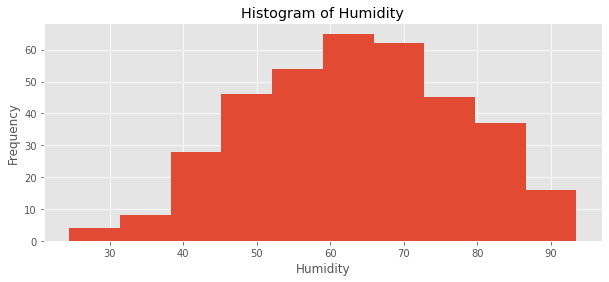

In [28]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")

plt.figure(figsize=(10, 4))
plt.hist(weather_df["humidity"])
plt.title("Histogram of Humidity")
plt.xlabel("Humidity")
plt.ylabel("Frequency")
plt.show()

### Temperature

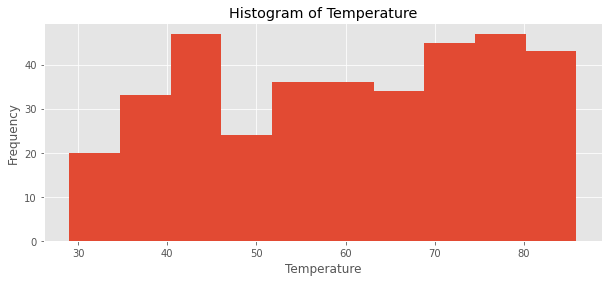

In [29]:
plt.figure(figsize=(10, 4))
plt.hist(weather_df["temperature"])
plt.title("Histogram of Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Question 6: Line Plot

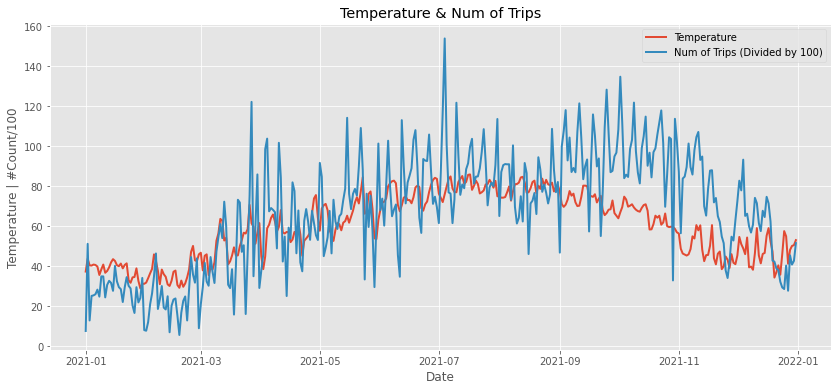

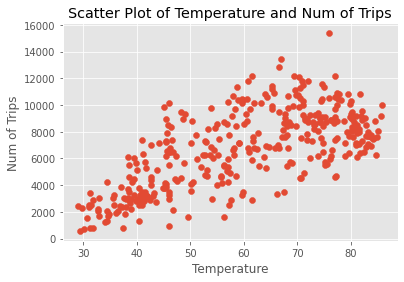

In [61]:
trip_count = bike_df.groupby("date").count()

plt.figure(figsize=(14, 6))
plt.plot(weather_df["date"], weather_df["temperature"], label="Temperature", linewidth=2)
plt.plot(trip_count.index, trip_count["ride_id"] / 100, label="Num of Trips (Divided by 100)", linewidth=2)
plt.title("Temperature & Num of Trips")
plt.xlabel("Date")
plt.ylabel("Temperature | #Count/100")
plt.legend()
plt.show()

plt.scatter(weather_df["temperature"], trip_count["ride_id"])
plt.title("Scatter Plot of Temperature and Num of Trips")
plt.xlabel("Temperature")
plt.ylabel("Num of Trips")
plt.show()

<blockquote>

It is observed that the warmer days are having more trips and vice versa which is understandable as riding a bike in cold days (especially with precipitation) is rare. It is also shown in the scatter plot which demonstrates the positive correlation between temperature and number of trips.